In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder
from copy import copy
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV


In [2]:
master_df = pd.read_csv('../data/us_kickstarter.zip')

In [3]:
len(master_df['sub_category'].unique())

146

In [5]:
from copy import copy
df = copy(master_df)
df = df.drop_duplicates('project_id', keep='first')

In [6]:
## remove live projects
df = df[df['state'] != 'live']

In [7]:
### successful, not successful
df['state'] = np.where(df['state'] == 'successful', 1, 0)

In [8]:
cols_to_select = ['category', 'category_parent_id', 'days_to_deadline', 'staff_pick', \
                 'location_type', 'location_state', 'location_id', 'goal', \
                  'launched_weekday', 'description_length', 'is_weekend_launch', \
                 'launched_week', 'launched_month']


In [9]:
target = df['state']
df = df[cols_to_select]

In [11]:
def set_dummies(df):
    
    # categories
    categories = pd.get_dummies(df['category'], prefix='_')
    df = df.join(categories)
    df.drop('category', axis=1)
    
    # state
    states = pd.get_dummies(df['location_state'], prefix='_')
    df = df.join(states)
    df.drop('location_state', axis = 1)
    
    # type
    types = pd.get_dummies(df['location_type'], prefix='_')
    df = df.join(types)
    df.drop('location_type', axis=1)
    
    return df

In [12]:
df = set_dummies(df)

In [13]:
df.drop('category', axis=1, inplace=True)

df.drop('location_type', axis=1, inplace=True)

df.drop('location_state', axis=1, inplace=True)

In [17]:
df['category_parent_id'] = df['category_parent_id'].fillna(0)

In [37]:
def train_model(Xtrain, ytrain):
    rf = RandomForestClassifier(n_estimators = 10, max_depth = 10 )
    rf.fit(Xtrain, ytrain)
    
    score = rf.score(Xtrain, ytrain)
    
    return rf, score
    

In [18]:
def lr_train(Xtrain, ytrain):
    lr = LogisticRegression()
    lr.fit(Xtrain, ytrain)
    
    score = lr.score(Xtrain, ytrain)
    
    return lr, score

In [19]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df, target, test_size=0.3, random_state=42)

In [20]:
to_scale = ['goal', 'description_length', 'days_to_deadline']

In [21]:
scaler = StandardScaler()

In [22]:
Xtrain.loc[:,to_scale] = scaler.fit_transform(Xtrain[to_scale])

C:\Users\sahil\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [23]:
Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size = 0.4, random_state=42)

In [24]:
Xval.loc[:, to_scale] = scaler.transform(Xval[to_scale])

In [34]:
Xtest.loc[:, to_scale] = scaler.transform(Xtest[to_scale])

In [25]:
lr = lr_train(Xtrain, ytrain)

C:\Users\sahil\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [26]:
lr[0]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
lr[1]

0.5552605636958372

In [29]:
lr[0].score(Xval, yval)

0.5549359588742703

In [30]:
from sklearn.metrics import classification_report

In [35]:
print (classification_report(ytest, lr[0].predict(Xtest)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6801
           1       0.56      1.00      0.71      8503

    accuracy                           0.56     15304
   macro avg       0.28      0.50      0.36     15304
weighted avg       0.31      0.56      0.40     15304



C:\Users\sahil\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [81]:
bagging = BaggingClassifier()

bagging.fit(Xtrain, ytrain)

bagging.score(Xtrain, ytrain)

0.9848545951516781

In [82]:
bagging.score(Xval, yval)

0.7034068136272545

In [53]:
# remove one column and check the performance of the model

def one_col_sensitivity_analysis():
    score_list = {}

    for col in cols_to_select:
        cols_copy = copy(cols_to_select)
        cols_copy.remove(col)
        df_copy = df[cols_copy]
        Xtrain, Xtest, ytrain, ytest = train_test_split(df, target, test_size=0.3, random_state=42)
        scaler = StandardScaler()
        Xtrain = scaler.fit_transform(Xtrain)
        
        
        _, score_list[col] = train_model(Xtrain, ytrain)
        
    return score_list
    

In [38]:
rf, score = train_model(Xtrain, ytrain)

In [39]:
score

0.7272930949500381

In [85]:
Xval[to_scale] = scaler.transform(Xval[to_scale])

In [40]:
rf.score(Xval, yval)

0.7200052278469984

In [41]:
print (classification_report(ytest, rf.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.75      0.56      0.64      6801
           1       0.71      0.85      0.77      8503

    accuracy                           0.72     15304
   macro avg       0.73      0.71      0.71     15304
weighted avg       0.73      0.72      0.72     15304



In [42]:
confusion_matrix(ytest, rf.predict(Xtest))

array([[3799, 3002],
       [1240, 7263]], dtype=int64)

In [48]:
from sklearn.metrics import roc_curve, auc

In [49]:
(fpr, tpr, threshold) = roc_curve(ytest, rf.predict(Xtest), pos_label=2)

C:\Users\sahil\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


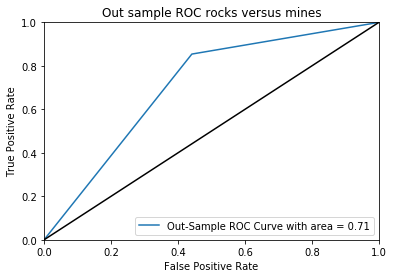

In [55]:
(fpr, tpr, thresholds) = roc_curve(ytest,rf.predict(Xtest))

area = auc(fpr,tpr)
plt.clf() #Clear the current figure
plt.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)

plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Out sample ROC')
plt.legend(loc="lower right")
plt.show()

In [94]:
area

0.7063817205731882

In [103]:
rf2, score = train_model(Xtrain[pd.Series(rf.feature_importances_, index=Xtrain.columns).\
                                sort_values(ascending=False)[:15].index], ytrain)

In [104]:
score

0.7247837971053457

In [105]:
rf2.score(Xval[pd.Series(rf.feature_importances_, index=Xtrain.columns).\
                                sort_values(ascending=False)[:15].index], yval)

0.6183236037291975

In [99]:
features = pd.Series(rf.feature_importances_, index = list(map(lambda x: x.replace('_', ''),\
                                                               Xtrain.columns))).sort_values(ascending=False)[:15]

In [100]:
def plot_imp_features(feature_imp):
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Important Features")
    plt.show()

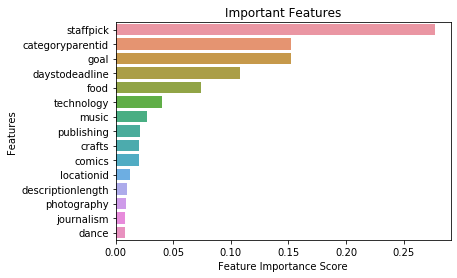

In [101]:
plot_imp_features(features)

In [56]:
live = pd.read_csv('us_kickstarter.zip')
live = live[live['state'] == 'live']

In [58]:
sample = live[live['id'] == 310704614.0]

In [59]:
testing = sample[cols_to_select]

In [60]:
testing = set_dummies(testing)

In [61]:
testing.drop(['category', 'location_type', 'location_state'], axis=1, inplace=True)

In [62]:
columns = Xtrain.columns

In [63]:
columns = list(set(columns) - set(testing.columns))

In [64]:
testing.loc[:, columns[0]] = 0

In [65]:
testing.iloc[0][columns[0]]

0.0

In [66]:
for col in columns:
    testing.loc[:, col] = 0

In [67]:
len(testing.columns)

83

In [68]:
testing = testing.dropna()

In [69]:
rf.predict(testing)

array([0])

In [70]:
rf.predict_proba(testing)

array([[0.68662019, 0.31337981]])

In [78]:
testing.iloc[0]['launched_weekday'] = 2
testing.iloc[0]['is_weekend_launch'] = False
testing.iloc[0]['days_to_deadline'] = 30

C:\Users\sahil\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\sahil\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\sahil\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [73]:
testing.loc[testing['category_parent_id'] == testing.iloc[0]['category_parent_id'], 'description_length'] = 145

In [86]:
testing.loc[testing['category_parent_id'] == testing.iloc[0]['category_parent_id'], 'goal'] = 1400

In [80]:
testing.loc[testing['category_parent_id'] == testing.iloc[0]['category_parent_id'], 'days_to_deadline'] = 30

In [90]:
testing.loc[testing['category_parent_id'] == testing.iloc[0]['category_parent_id'], 'launched_weekday'] = 1

In [91]:
testing.loc[testing['category_parent_id'] == testing.iloc[0]['category_parent_id'], 'is_weekend_launch'] = False

In [92]:
rf.predict(testing)

array([0])

In [93]:
rf.predict_proba(testing)

array([[0.79862158, 0.20137842]])

In [84]:
rf.predict(testing)

array([0])

In [127]:
success = pd.DataFrame(Xtest[ytest==1].iloc[5]).T

In [129]:
rf.predict(success)

array([1])

In [130]:
rf.predict_proba(success)

array([[0.08007351, 0.91992649]])

In [111]:
success.loc[6961, 'description_length'] = 140

In [117]:
master_df.loc[6961]['project_url']

'https://www.kickstarter.com/projects/seanrowe/sean-rowe-is-going-rogue?ref=discovery_category_newest'

In [113]:
rf.predict(success)

array([1])

In [114]:
rf.predict_proba(success)

array([[0.20799849, 0.79200151]])

In [26]:
pd.Series(rf.feature_importances_, index=df.columns).sort_values(ascending=False)

goal                  0.189903
category_parent_id    0.115420
staff_pick            0.111839
days_to_deadline      0.098611
location_id           0.096493
description_length    0.085242
launched_week         0.076162
location_state        0.068437
category              0.059190
launched_month        0.043324
launched_weekday      0.039492
location_type         0.008290
is_weekend_launch     0.007598
dtype: float64

In [27]:
features = pd.Series(rf.feature_importances_, index=df.columns).sort_values(ascending=False)

In [28]:
rf2, score2 = train_model(Xtrain[features[features > 0.05].index], ytrain)

In [29]:
rf2.score(Xval[features[features > 0.05].index], yval)

0.7215735819465017